This code is based of the official [tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan) with the resnet generator from this [tutorial](https://www.youtube.com/watch?v=VzIO5_R9XEM&ab_channel=DigitalSreeni). All of this is based of the [cycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

Load in Data and Preprocess

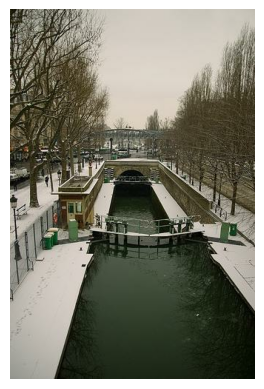

In [ ]:
all_sunny = tf.data.Dataset.list_files("drive/My Drive/Colab Notebooks/sunny/*.jpg")
all_snowy = tf.data.Dataset.list_files("drive/My Drive/Colab Notebooks/snowA/snow/*.jpg")



def parse_image(filename):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  
  #slice off the alpha channel
  image = image[:,:,:3]
  # image = tf.image.resize(image, [256, 256],
  #                         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image

all_sunny = all_snowy.map(parse_image)
all_snowy = all_snowy.map(parse_image)

test_snowy = all_snowy.take(100) 
train_snowy = all_snowy.skip(100)


test_sunny = all_sunny.take(100) 
train_sunny = all_sunny.skip(100)

image = next(iter(test_snowy))

def show(image):

  plt.figure()
  plt.imshow(image)
  plt.axis('off')

show(image)



In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_mirror(image):

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image):
  # print(f'size: {tf.shape(image)}')
  image = tf.image.resize(image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  


  image = random_mirror(image)
  image = normalize(image)

  return image

In [ ]:
def preprocess_image_test(image):
  image = tf.image.resize(image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)

  return image

In [ ]:
train_snowy = train_snowy.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_sunny = train_sunny.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_snowy = test_snowy.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_sunny = test_sunny.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

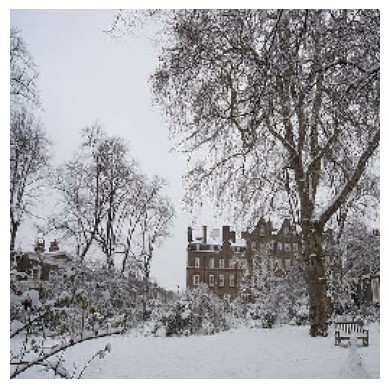

In [ ]:
sample_snowy = next(iter(train_snowy))
sample_sunny = next(iter(train_sunny))

show(tf.squeeze(sample_snowy)*0.5+0.5)

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
%pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-zdg2dbhd
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-zdg2dbhd
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101078 sha256=8256d03767dd0359e380ee47db7643d213080a13839eed115de382a03cab123a
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2fvtk3x/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [ ]:
# Resnet blocks to be used in the generator
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
def resnet_block(n_filters, input_layer):
  print(input_layer)
	# weight initialization
  init = RandomNormal(stddev=0.02)
	# first convolutional layer
  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation('relu')(g)
	# second convolutional layer
  g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
  g = Concatenate()([g, input_layer])
  return g

In [ ]:
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# 64 filters, 49 size kernel
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# 128 filters , 9 size kernel
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# 256  filters, 9 size kernel
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# Resnet at 256 filters
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# 128  filters, 9 size kernel
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# 64 filters
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# 3  filters
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# 64 filters, 16 size kernel
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# 128 filters 16 size kernel
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# 256 filter 16 size
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# 512 filters 16 size kernel
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [ ]:
#init generators and discriminators
generator_g = define_generator(sample_snowy.shape[1:])
generator_f = define_generator(sample_sunny.shape[1:])

discriminator_x = define_discriminator(sample_snowy.shape[1:])
discriminator_y = define_discriminator(sample_snowy.shape[1:])


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='activation_2/Relu:0', description="created by layer 'activation_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 512), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 768), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1024), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1280), dtype=tf.float32, name=None), name='concatenate_3/concat:0', description="created by layer 'concatenate_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1536), dtype=tf.float32, name=None), name='concatenate_4/concat:0', description="created by layer 'concaten

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## Loss functions

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Training

Note: This model is trained for fewer epochs (100) than the paper (200) for cost in computing unit reasoning, which will result in lower quality images.

In [ ]:
EPOCHS = 100

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

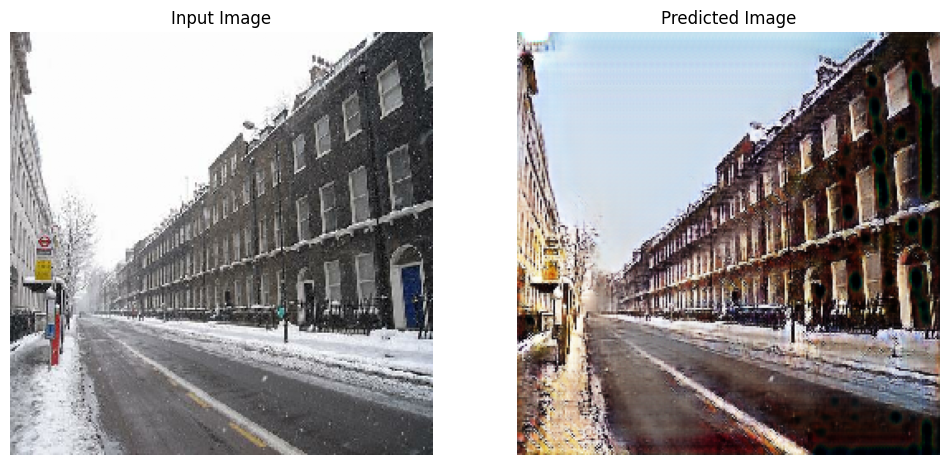

Time taken for epoch 68 is 130.49666237831116 sec

....

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_snowy, train_sunny)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_snowy) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_snowy)


  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

In [ ]:
# Run the trained model on the test dataset
for inp in test_snowy.take(15):
  generate_images(generator_g, inp)

## Next steps

Dystopian, other weather, better data.